Build a vanilla RNN using glove embeddings

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gzip
import json

import torch as th
import torch.nn.functional as F
from torch import nn
from torch import optim
from torch.nn import Embedding
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
from torchtext.vocab import vocab, Vocab, GloVe
from torchtext.data.utils import get_tokenizer
from torchmetrics import MeanSquaredError

import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger, WandbLogger

from typing import Callable, List, Tuple
from functools import reduce
from collections import OrderedDict

from tqdm import tqdm

import optuna
from optuna.visualization import plot_parallel_coordinate, plot_contour
from optuna.importance import get_param_importances

import matplotlib
matplotlib.rcParams["figure.facecolor"] = "white"

import wandb

In [3]:
#!python -m spacy download en_core_web_sm

In [4]:
PAD_TOKEN = "<pad>"
EOS_TOKEN = "<eos>"
UNK_TOKEN = "<unk>"
SPECIAL_TOKENS = (PAD_TOKEN, EOS_TOKEN, UNK_TOKEN)

In [5]:
# spacy tokenizer
tokenizer = get_tokenizer('spacy', language='en_core_web_sm')

# glove embeddings --> vocab
embedding_dim = 100
embedding_vecs = GloVe(name='6B', dim=embedding_dim)

embedding_dict = OrderedDict()
embedding_dict.update({PAD_TOKEN: 1})
embedding_dict.update({EOS_TOKEN: 1})
embedding_dict.update({UNK_TOKEN: 1})
embedding_dict.update(embedding_vecs.stoi)
# min_freq=0 is a hack to read in the 0th token from embedding_vecs.stoi
voc = vocab(embedding_dict, min_freq=0)
voc.set_default_index(voc[UNK_TOKEN])

# glove embeddings --> embedding module
embedding = Embedding.from_pretrained(
    embedding_vecs.vectors, freeze=True, padding_idx=voc[PAD_TOKEN]
)

# Train on disaster tweet dataset

Start with a known-easy dataset to sanity check the model. Disaster tweets dataset from Kaggle.

In [6]:
class TwitterDisasterDataset(Dataset):
    """
    Disaster tweet data. Download: dataset from 
    https://www.kaggle.com/c/nlp-getting-started, rename the `train.csv` 
    as `data_disaster_tweets.csv`.
    """
    def __init__(self, tokenizer: Callable, voc: Vocab) -> None:
        self.tokenizer = tokenizer
        self.voc = voc
        
        # Load data and remove unnecessary columns
        df = pd.read_csv("data/data_disaster_tweets.csv")
        df = df[["text", "target"]]
        df = df.reset_index(drop=True)
        
        # TODO: test
        # print("Warning: testing only with 1000 data points")
        # df = df.iloc[0:1000, :] 
        
        nz_texts = []  # numericalized_texts
        seq_lengths = []  # sequence lengths
        for text in tqdm(df.text):
            nz_text = th.tensor(self.voc(self.tokenizer(text)))
            nz_texts.append(nz_text)
            seq_lengths.append(len(nz_text))
        
        # shape of x is: T x B, where T is length of longest seq, B is batch size
        self.seqs = pad_sequence(nz_texts, padding_value=self.voc[PAD_TOKEN])
        self.seq_lengths = th.tensor(seq_lengths)
        self.targets = th.tensor(df.target).float()
        
    def __len__(self) -> int:
        return len(self.targets)
    
    def __getitem__(self, i: int) -> Tuple[Tuple[th.Tensor, int], float]:
        seq = self.seqs[:, i]
        seq_length = self.seq_lengths[i]
        targets = self.targets[i]
        return (seq, seq_length), targets

In [7]:
%%time
full_ds = TwitterDisasterDataset(tokenizer, voc)

num_train = int(0.7 * len(full_ds))
num_val = int(0.15 * len(full_ds))
num_test = len(full_ds) - num_train - num_val
batch_size = 64

train_ds, val_ds, test_ds = random_split(full_ds, [num_train, num_val, num_test])

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False)  
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

100%|█████████████████████████████████████████████████████████| 7613/7613 [00:02<00:00, 3737.33it/s]


CPU times: user 2.06 s, sys: 135 ms, total: 2.2 s
Wall time: 2.17 s


In [8]:
test = next(iter(val_dl))
assert len(test) == 2
assert len(test[0]) == 2
assert isinstance(test[0][0], th.Tensor)
assert isinstance(test[0][1], th.Tensor)
assert isinstance(test[1], th.Tensor)

In [17]:
class VanillaRNN(pl.LightningModule):
    def __init__(
        self, embedding: nn.Embedding, hidden_size: int = 128, num_layers: int = 1,
        lr: float = 1e-3, dropout: float = 0.5
    ):
        super().__init__()
        self.embedding = embedding
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lr = lr
        self.dropout = dropout
        
        self.save_hyperparameters(ignore=['embedding'])

        # TODO: try using bidirectional in rnn
        self.rnn = nn.RNN(
            self.embedding.embedding_dim, self.hidden_size, batch_first=True, 
            dropout=self.dropout, num_layers=self.num_layers
        )
        self.fc = nn.Linear(self.hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x: List[th.Tensor]) -> th.Tensor:
        assert len(x) == 2
        seqs, seq_lengths = x
        embedded = self.embedding(seqs)
        packed = pack_padded_sequence(
            embedded, seq_lengths, batch_first=True, enforce_sorted=False
        )
        
        # TODO: try usng a randomly generated initial hidden state 
        # (instead of the zero vector default)
        _, h_n = self.rnn(packed)
        
        assert h_n.shape[0], h_n.shape[2] == (1, self.hidden_size)
        
        x = h_n[-1, :, :]
        x = self.fc(x)
        x = self.sigmoid(x)
        return x
    
    def training_step(self, batch: th.Tensor, batch_idx: int) -> th.Tensor:
        return self.generalized_step(batch, batch_idx, "train")

    def validation_step(self, batch: th.Tensor, batch_idx: int) -> th.Tensor:
        return self.generalized_step(batch, batch_idx, "val")

    def test_step(self, batch: th.Tensor, batch_idx: int) -> th.Tensor:
        return self.generalized_step(batch, batch_idx, "test")
    
    def generalized_step(self, batch: th.Tensor, batch_idx: int, label: str) -> th.Tensor:
        x, y = batch
        predicted = self(x).squeeze(1)
        loss = F.mse_loss(predicted, y)
        self.log(f"{label}_loss", loss)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), self.lr)
        return optimizer

In [18]:
# vrnn = VanillaRNN(embedding)
# trainer = Trainer()
# lr_finder = trainer.tuner.lr_find(vrnn, train_dl, val_dl, num_training=1000)
# lr_finder.plot(suggest=True)
# lr_finder.suggestion()

In [ ]:
study = optuna.create_study()

train_ds, val_ds, test_ds = random_split(full_ds, [num_train, num_val, num_test])
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False) 
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

for i in tqdm(range(10)):
    trial = study.ask()
    hparams = dict(
        hidden_size=trial.suggest_int('hidden_size', 64, 256),
        dropout=trial.suggest_uniform('dropout', 0.1, 0.8),
        lr=trial.suggest_loguniform('lr', 1e-4, 1e-2),
        num_layers=trial.suggest_categorical('num_layers', [1,2,3,4,5,6])
    )
    
    vrnn = VanillaRNN(embedding, **hparams)
    logger = WandbLogger(project='expt1b_long', log_model=False)
    trainer = pl.Trainer(max_epochs=100, logger=logger)
    trainer.fit(vrnn, train_dl, val_dl)
    wandb.finish()
    
    val_loss = trainer.logged_metrics['val_loss']
    study.tell(trial, val_loss)

[I 2022-01-12 19:50:20,162] A new study created in memory with name: no-name-cf0eb64f-4c1d-48bc-a554-ad55d6f18e04
  0%|                                                                        | 0/10 [00:00<?, ?it/s]GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs



  | Name      | Type      | Params
----------------------------------------
0 | embedding | Embedding | 40.0 M
1 | rnn       | RNN       | 378 K 
2 | fc        | Linear    | 226   
3 | sigmoid   | Sigmoid   | 0     
----------------------------------------
378 K     Trainable params
40.0 M    Non-trainable params
40.4 M    Total params
161.516   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/Users/dennis/repos/sentimental/.venv/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/dennis/repos/sentimental/.venv/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,▅▄▃▃▃▂▃▂▃▃▃▃▄▃▂▁▁▃▄▃▄▄▃▅▂▂█▃▃▂▂▄▃▃▃▄▃▃▂▃
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,▂▃▂▂▂▄▁▁▂▂▂▃▂▂▂▂▂▂▂▂▄▃▂▄▁▁▁▃▂▁▃▂▃▁█▁▅▂▂▂
epoch,99
train_loss,0.25572
trainer/global_step,8399
val_loss,0.24846


 10%|██████                                                      | 1/10 [20:22<3:03:18, 1222.04s/it]GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs



  | Name      | Type      | Params
----------------------------------------
0 | embedding | Embedding | 40.0 M
1 | rnn       | RNN       | 104 K 
2 | fc        | Linear    | 171   
3 | sigmoid   | Sigmoid   | 0     
----------------------------------------
104 K     Trainable params
40.0 M    Non-trainable params
40.1 M    Total params
160.418   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/Users/dennis/repos/sentimental/.venv/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/dennis/repos/sentimental/.venv/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,▃▆▃▃▃█▅▃▄▃▄▄▅▄▃▄▄█▅▄▄▄▄▃▃▃▆▅▇▄▄▄▄▃▃▃▃▄▁▄
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,▃▁▆▁▂▂▂█▂▂▄▃▂▃▂▂▃▂▃▄▂▂▃▂▃▃▃▂▄▂▂▃▄▂▂▃▃▂▃▅
epoch,99
train_loss,0.24922
trainer/global_step,8399
val_loss,0.26346


 20%|████████████▏                                                | 2/10 [27:58<1:42:52, 771.62s/it]GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs



  | Name      | Type      | Params
----------------------------------------
0 | embedding | Embedding | 40.0 M
1 | rnn       | RNN       | 340 K 
2 | fc        | Linear    | 214   
3 | sigmoid   | Sigmoid   | 0     
----------------------------------------
340 K     Trainable params
40.0 M    Non-trainable params
40.3 M    Total params
161.363   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/Users/dennis/repos/sentimental/.venv/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/dennis/repos/sentimental/.venv/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,███▆▇▇▇▆█▇▅▅▅▄▃▄▅▄▄▄▄▅▅▄▃▄▃▂▂▁▃▂▄▄▄▂▃▂▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,▁▁▁▁▂▂▂▃▃▄▅▄▄▄▅▅▄▅▅▅▅▅▆▆▇▆▆▆▇▇▆▇▇██▇████
epoch,99
train_loss,0.00576
trainer/global_step,8399
val_loss,0.3209


 30%|██████████████████▎                                          | 3/10 [40:47<1:29:53, 770.51s/it]GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs



  | Name      | Type      | Params
----------------------------------------
0 | embedding | Embedding | 40.0 M
1 | rnn       | RNN       | 210 K 
2 | fc        | Linear    | 249   
3 | sigmoid   | Sigmoid   | 0     
----------------------------------------
210 K     Trainable params
40.0 M    Non-trainable params
40.2 M    Total params
160.842   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/Users/dennis/repos/sentimental/.venv/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/dennis/repos/sentimental/.venv/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

# Twitter sentiment dataset

In [190]:
class TwitterDataset(Dataset):
    """
    Sentiment data from tweets. Raw dataset downloaded from: 
    http://help.sentiment140.com/for-students
    """
    def __init__(self, tokenizer: Callable, voc: Vocab) -> None:
        self.tokenizer = tokenizer
        self.voc = voc
        
        # Load data and remove unnecessary columns
        df = pd.read_csv("data/data_twitter_sentiment.csv", header=None, encoding='latin-1')
        df = df.rename(columns={
            0: "sentiment_raw",
            5: "text",
        })
        # raw sentiment data is from 0 to 4. Scale it to 0 and 1.
        df["sentiment"] = df.sentiment_raw / 4
        df = df[["sentiment", "text"]]
        df = df.reset_index(drop=True)
        # df = df.iloc[0:1000, :]  # TODO: test
        
        nz_texts = []  # numericalized_texts
        seq_lengths = []  # sequence lengths
        for text in tqdm(df.text):
            nz_text = th.tensor(self.voc(self.tokenizer(text)))
            nz_texts.append(nz_text)
            seq_lengths.append(len(nz_text))
        
        # shape of x is: T x B, where T is length of longest seq, B is batch size
        self.seqs = pad_sequence(nz_texts, padding_value=self.voc[PAD_TOKEN])
        self.seq_lengths = th.tensor(seq_lengths)
        self.sentiments = th.tensor(df.sentiment).float()
        
    def __len__(self) -> int:
        return len(self.sentiments)
    
    def __getitem__(self, i: int) -> Tuple[Tuple[th.Tensor, int], float]:
        seq = self.seqs[:, i]
        seq_length = self.seq_lengths[i]
        sentiment = self.sentiments[i]
        return (seq, seq_length), sentiment

In [191]:
%%time
full_ds = TwitterDataset(tokenizer, voc)

100%|██████████████████████████████████████████████████| 1600000/1600000 [02:35<00:00, 10296.50it/s]


CPU times: user 2min 45s, sys: 12.8 s, total: 2min 57s
Wall time: 2min 53s


In [192]:
full_ds.seqs.shape

torch.Size([181, 1600000])

In [193]:
num_train = int(0.7 * len(full_ds))
num_val = int(0.15 * len(full_ds))
num_test = len(full_ds) - num_train - num_val
batch_size = 64

train_ds, val_ds, test_ds = random_split(full_ds, [num_train, num_val, num_test])

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
# no need to shuffle val or test dl's
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False)  
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

In [194]:
test = next(iter(val_dl))

In [195]:
class LitVanillaRNN(pl.LightningModule):
    def __init__(
        self, embedding: nn.Embedding, hidden_size: int = 128, num_layers: int = 1,
        lr: float = 1e-3, dropout: float = 0.5,
    ):
        super().__init__()
        self.embedding = embedding
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lr = lr
        self.dropout = dropout

        # TODO: try using dropout in rnn
        # TODO: try using bidirectional in rnn
        self.rnn = nn.RNN(
            self.embedding.embedding_dim, self.hidden_size, batch_first=True, 
            dropout=self.dropout, num_layers=self.num_layers
        )
        self.fc = nn.Linear(self.hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x: List[th.Tensor]) -> th.Tensor:
        assert len(x) == 2
        seqs, seq_lengths = x
        embedded = self.embedding(seqs)
        packed = pack_padded_sequence(
            embedded, seq_lengths, batch_first=True, enforce_sorted=False
        )
        
        # TODO: try usng a randomly generated initialhidden state 
        # (instead of the zero vector default)
        _, h_n = self.rnn(packed)
        
        assert h_n.shape[0], h_n.shape[2] == (1, self.hidden_size)
        
        x = h_n[-1, :, :]
        x = self.fc(x)
        x = self.sigmoid(x)
        return x
    
    def training_step(self, batch: th.Tensor, batch_idx: int) -> th.Tensor:
        return self.generalized_step(batch, batch_idx, "train")

    def validation_step(self, batch: th.Tensor, batch_idx: int) -> th.Tensor:
        return self.generalized_step(batch, batch_idx, "val")

    def test_step(self, batch: th.Tensor, batch_idx: int) -> th.Tensor:
        return self.generalized_step(batch, batch_idx, "test")
    
    def generalized_step(self, batch: th.Tensor, batch_idx: int, label: str) -> th.Tensor:
        x, y = batch
        predicted = self(x).squeeze(1)
        loss = F.mse_loss(predicted, y)
        self.log(f"{label}_loss", loss)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), self.lr)
        return optimizer

In [196]:
embedding = Embedding.from_pretrained(
    embedding_vecs.vectors, freeze=True, padding_idx=voc[PAD_TOKEN]
)

vrnn = LitVanillaRNN(embedding)

/Users/dennis/repos/sentimental/.venv/lib/python3.9/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [197]:
test = next(iter(val_dl))
print(vrnn(test[0]).shape)
# print(vrnn(test[0]))

torch.Size([64, 1])


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/dennis/repos/sentimental/.venv/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/dennis/repos/sentimental/.venv/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Finding best initial lr:   0%|          | 0/1000 [00:00<?, ?it/s]

Restoring states from the checkpoint path at /Users/dennis/repos/sentimental/model_creation/lr_find_temp_model_7c1eb9fb-1809-4f24-b8a6-8319192d3fa5.ckpt
/var/folders/fl/9k8dsknn4b1_q6cnfjypzvrw0000gn/T/ipykernel_99390/2888036244.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0.03926449353995995

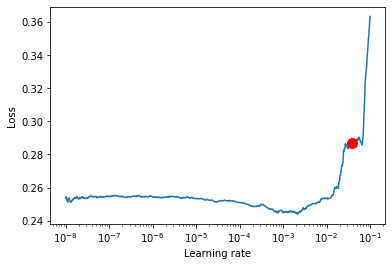

In [198]:
vrnn = LitVanillaRNN(embedding, dropout=0.5, lr=1e-4, num_layers=3)
trainer = pl.Trainer(auto_lr_find=True)
lr_finder = trainer.tuner.lr_find(vrnn, train_dl, val_dl, max_lr=1e-1, num_training=1000)
fig = lr_finder.plot(suggest=True)
fig.show()
lr_finder.suggestion()

In [207]:
%tensorboard --logdir lightning_logs

In [208]:
# continue here:
expt = "drop0p5_layers3_lr1e-4"
dropout = 0.5
num_layers = 3
lr = 1e-3
for i in range(3):
    print(f"ITERATION {i}")
    vrnn = LitVanillaRNN(embedding, dropout=dropout, lr=lr, num_layers=num_layers)
    # logger = TensorBoardLogger("./lightning_logs", name=expt)
    logger = WandbLogger("./lightning_logs", name=expt, project='my-test-project')
    trainer = pl.Trainer(max_epochs=10, logger=logger)
    # trainer = pl.Trainer(max_epochs=100)

    # random splits for datasets
    train_ds, val_ds, test_ds = random_split(full_ds, [num_train, num_val, num_test])
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False) 
    test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

    # training
    print("TEST")
    trainer.test(vrnn, test_dl)
    print("FIT")
    trainer.fit(vrnn, train_dl, val_dl)
    print("TEST")
    trainer.test(vrnn, test_dl)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Missing logger folder: ./lightning_logs/drop0p5_layers3_lr1e-4


ITERATION 0
TEST


/Users/dennis/repos/sentimental/.venv/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]


  | Name      | Type             | Params
-----------------------------------------------
0 | embedding | Embedding        | 40.0 M
1 | rnn       | RNN              | 95.5 K
2 | fc        | Linear           | 129   
3 | sigmoid   | Sigmoid          | 0     
4 | mse       | MeanSquaredError | 0     
-----------------------------------------------
95.6 K    Trainable params
40.0 M    Non-trainable params
40.1 M    Total params
160.382   Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.2508750259876251, 'test_mse': 0.2508750259876251}
--------------------------------------------------------------------------------
FIT


Validation sanity check: 0it [00:00, ?it/s]

/Users/dennis/repos/sentimental/.venv/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/dennis/repos/sentimental/.venv/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

TEST


/Users/dennis/repos/sentimental/.venv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:688: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


ITERATION 1


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.


KeyboardInterrupt



# Misc: code for future models

In [ ]:
# for when you're building vocab from training dataset

seqs = ["I like air.", "I like the sun.", "He likes the sun."]
tokenizer = get_tokenizer('spacy', language='en_core_web_sm')
tk_seqs = [tokenizer(s) + [EOS_TOKEN] for s in seqs]
# all_tks = reduce(lambda x, y: x + y, tk_seqs)
# all_tks = [all_tks]  # build_vocab_from_iterator requires each item to be iterator
vocab = build_vocab_from_iterator(tk_seqs, specials=SPECIAL_TOKENS)
# TODO: consider whether to include this
# vocab.set_default_index(-1)

# numericalized sequences; must be tensor to be input to pad_sequence
nz_seqs = [th.tensor(vocab(tk_seq)) for tk_seq in tk_seqs]
nz_seqs_padded = pad_sequence(nz_seqs, padding_value=vocab[PAD_TOKEN])

Parse and clean data into dataframe

In [3]:
# Use example code from
# https://colab.research.google.com/drive/1Zv6MARGQcrBbLHyjPVVMZVnRWsRnVMpV#scrollTo=7igYuRaV4bF7

data = []
with gzip.open("reviews_Office_Products_5.json.gz") as f:
    for l in f:
        data.append(json.loads(l.strip()))
    
# total length of list, this number equals total number of products
print(f"Total num items in dataset: {len(data)}")

df = pd.DataFrame.from_dict(data)
df = df.loc[:, ["reviewText", "overall"]]
df = df.rename(columns={"reviewText": "review_text"})

FileNotFoundError: [Errno 2] No such file or directory: 'reviews_Office_Products_5.json.gz'

In [32]:
# manual mapping from "overall rating" to "sentiment"
MIN_RATING = 1
MAX_RATING = 5
NEUTRAL_RATING = 3.5
def rating_to_sentiment(rating, neutral=NEUTRAL_RATING):
    """
    Shifts scale to have `neutral` correspond to 0 sentiment, 1 to correspond to -1 sentiment,
    and 5 to correspond to +1 sentiment. The mapping is a piecewise function, linear from min rating to neutral,
    and again linear from neutral rating to max.
    """
    assert MIN_RATING <= rating <= MAX_RATING
    if rating <= neutral:
        d = neutral - MIN_RATING
        return -1 + (rating - MIN_RATING) / d
    else:
        d = MAX_RATING - neutral
        return (rating - neutral) / d

assert rating_to_sentiment(3.5) == 0
assert rating_to_sentiment(5) == 1
assert rating_to_sentiment(1) == -1
assert rating_to_sentiment(3, neutral=3) == 0
assert rating_to_sentiment(4, neutral=3) == 0.5
assert rating_to_sentiment(2, neutral=3) == -0.5
assert rating_to_sentiment(4) < rating_to_sentiment(4, neutral=3)
assert rating_to_sentiment(2) < rating_to_sentiment(2, neutral=3)

In [33]:
df["sentiment"] = df.overall.apply(rating_to_sentiment)

In [34]:
df.head()

,review_text,overall,sentiment
0,"I bought my first HP12C in about 1984 or so, a...",5.0,1.0
1,WHY THIS BELATED REVIEW? I feel very obliged t...,5.0,1.0
2,I have an HP 48GX that has been kicking for mo...,2.0,-0.6
3,I've started doing more finance stuff recently...,5.0,1.0
4,For simple calculations and discounted cash fl...,5.0,1.0
